In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud,STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import re,string
from sklearn.model_selection import train_test_split
from nltk.corpus import wordnet
import re
import warnings
import torch
warnings.filterwarnings('ignore')

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#torch.cuda.is_available()
print(device)

cuda


In [3]:
%%time
df = pd.read_csv('survey_comment.csv', encoding='latin-1')

CPU times: total: 0 ns
Wall time: 20 ms


In [4]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Acer\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [5]:
df = df.drop(columns=['Unnamed: 0'])
df

verbatim_text
0     There was no salad dressing. The staff informe...
1                                         Not a choice.
2                       More variety and bigger snacks.
3     Serving pretzels and cookies in first class wa...
4     More inflight selections to purchase for full ...
...                                                 ...
9419  tapas box needs better pita chips. the provide...
9420  My flight attendant missed my drink order 2x a...
9421                                                Mo.
9422  without a smartphone, not much to eat. we pack...
9423        Offering coffee or tea would also be great.

[9424 rows x 1 columns]

In [6]:
#Customize stopword as per data
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
new_stopwords = ["would","shall","could","might"]
stop_words.extend(new_stopwords)
stop_words.remove("not")
stop_words=set(stop_words)
print(stop_words)

{"hasn't", 'at', 'before', 'isn', 'myself', 'where', 'aren', 'over', 'too', "hadn't", "mustn't", 'the', 'same', 'wasn', 'hadn', 'between', 'about', 'in', 'under', "couldn't", 'being', 'so', 'these', 'is', 'during', 'be', 'out', 'here', 'having', 'both', 'are', 'you', 'into', 'any', 'each', 'couldn', "isn't", 'down', 'few', 'other', 'their', 'as', 'most', 'until', 'hers', 'of', 'for', 'o', 'needn', 'itself', "shan't", 'whom', 'up', 'than', 'or', "it's", 'when', 've', 'themselves', 'what', 'its', 'herself', 'against', 'why', 'been', "don't", "mightn't", "that'll", 'from', "you're", 'doesn', 'him', 'it', 'yourself', 'no', 'has', 'just', 'me', 'again', "she's", 'shall', 'only', 's', 'this', 'she', "you've", 'by', 'but', 're', 'we', 'shan', "shouldn't", 'own', 'then', 'with', 'how', 'his', 'll', 'all', 'a', 'didn', 'wouldn', 'below', 'more', 'mustn', 'weren', 'once', 't', "you'd", 'can', 'shouldn', 'theirs', 'there', 'ma', 'does', "aren't", 'our', "you'll", 'he', "won't", "didn't", 'because

## Data Cleaning and Preprocessing pipeline

In [7]:
#Removing special character
def remove_special_character(content):
    return re.sub('\W+',' ', content )#re.sub('\[[^&@#!]]*\]', '', content)

# Removing URL's
def remove_url(content):
    return re.sub(r'http\S+', '', content)

#Removing the stopwords from text
def remove_stopwords(content):
    clean_data = []
    for i in content.split():
        if i.strip().lower() not in stop_words and i.strip().lower().isalpha():
            clean_data.append(i.strip().lower())
    return " ".join(clean_data)

# Expansion of english contractions
def contraction_expansion(content):
    content = re.sub(r"won\'t", "would not", content)
    content = re.sub(r"can\'t", "can not", content)
    content = re.sub(r"don\'t", "do not", content)
    content = re.sub(r"shouldn\'t", "should not", content)
    content = re.sub(r"needn\'t", "need not", content)
    content = re.sub(r"hasn\'t", "has not", content)
    content = re.sub(r"haven\'t", "have not", content)
    content = re.sub(r"weren\'t", "were not", content)
    content = re.sub(r"mightn\'t", "might not", content)
    content = re.sub(r"didn\'t", "did not", content)
    content = re.sub(r"n\'t", " not", content)
    content = re.sub(r"\'re", " are", content)
    content = re.sub(r"\'s", " is", content)
    content = re.sub(r"\'d", " would", content)
    content = re.sub(r"\'ll", " will", content)
    content = re.sub(r"\'t", " not", content)
    content = re.sub(r"\'ve", " have", content)
    content = re.sub(r"\'m", " am", content)
    return content

#Data preprocessing
def data_cleaning(content):
    content = contraction_expansion(content)
    content = remove_special_character(content)
    content = remove_url(content)
    
    content = remove_stopwords(content)    
    return content

In [8]:
%%time
pd.options.display.max_colwidth = 1000
#Data cleaning
df['comments_clean']=df['verbatim_text'].apply(data_cleaning)
df

CPU times: total: 141 ms
Wall time: 184 ms


verbatim_text  \
0                                                                  There was no salad dressing. The staff informed me that the flight did not receive any salad dressing for any of the meals.   
1                                                                                                                                                                                Not a choice.   
2                                                                                                                                                              More variety and bigger snacks.   
3                                                             Serving pretzels and cookies in first class was extremely disappointing. Really, a little thought from chef would go a long way.   
4                                                                                                                                         More inflight selections to purchase for full meals.   
...                                                                                                                                                                                        ...   
9419                                                                                                      tapas box needs better pita chips. the provide chips are always crumbled and greasy.   
9420                     My flight attendant missed my drink order 2x and in the end never received the drink I requested. At that point, we were getting ready to land and it did not matter.   
9421                                                                                                                                                                                       Mo.   
9422  without a smartphone, not much to eat. we packed our own food. your email with food options to buy before our flight did not arrive in our inbox until after we left for our trip to NY.   
9423                                                                                                                                               Offering coffee or tea would also be great.   

                                                                                                  comments_clean  
0                                          salad dressing staff informed flight not receive salad dressing meals  
1                                                                                                     not choice  
2                                                                                          variety bigger snacks  
3            serving pretzels cookies first class extremely disappointing really little thought chef go long way  
4                                                                        inflight selections purchase full meals  
...                                                                                                          ...  
9419                                      tapas box needs better pita chips provide chips always crumbled greasy  
9420  flight attendant missed drink order end never received drink requested point getting ready land not matter  
9421                                                                                                          mo  
9422     without smartphone not much eat packed food email food options buy flight not arrive inbox left trip ny  
9423                                                                              offering coffee tea also great  

[9424 rows x 2 columns]

### Data Overview

In [9]:
#Checking for missing value
df.isna().sum()

verbatim_text     0
comments_clean    0
dtype: int64

In [10]:
df['comments_clean'].describe()

count     9424
unique    7691
top           
freq       946
Name: comments_clean, dtype: object

In [11]:
print('Unique reviews:%s' % df.comments_clean.nunique())

Unique reviews:7691


## Visualization of Important Words from Comments

CPU times: total: 1.77 s
Wall time: 1.89 s


(-0.5, 1499.5, 799.5, -0.5)

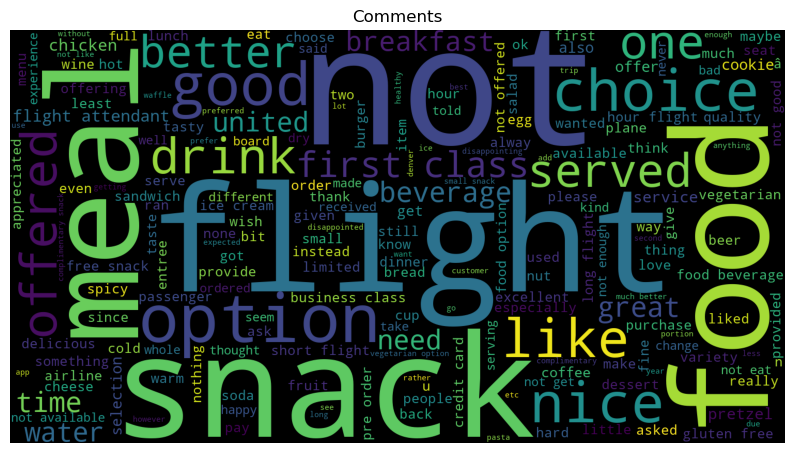

In [12]:
%%time
sentences=df['comments_clean']
neg=' '.join(map(str,sentences))
  
neg_wordcloud = WordCloud(width = 1500, height = 800, 
                background_color ='black', 
                stopwords = stop_words, 
                min_font_size = 15).generate(neg) 

plt.figure(figsize=(10,10))
plt.imshow(neg_wordcloud)
plt.title('Comments')
plt.axis('off')

## Basic Statistic of Review data

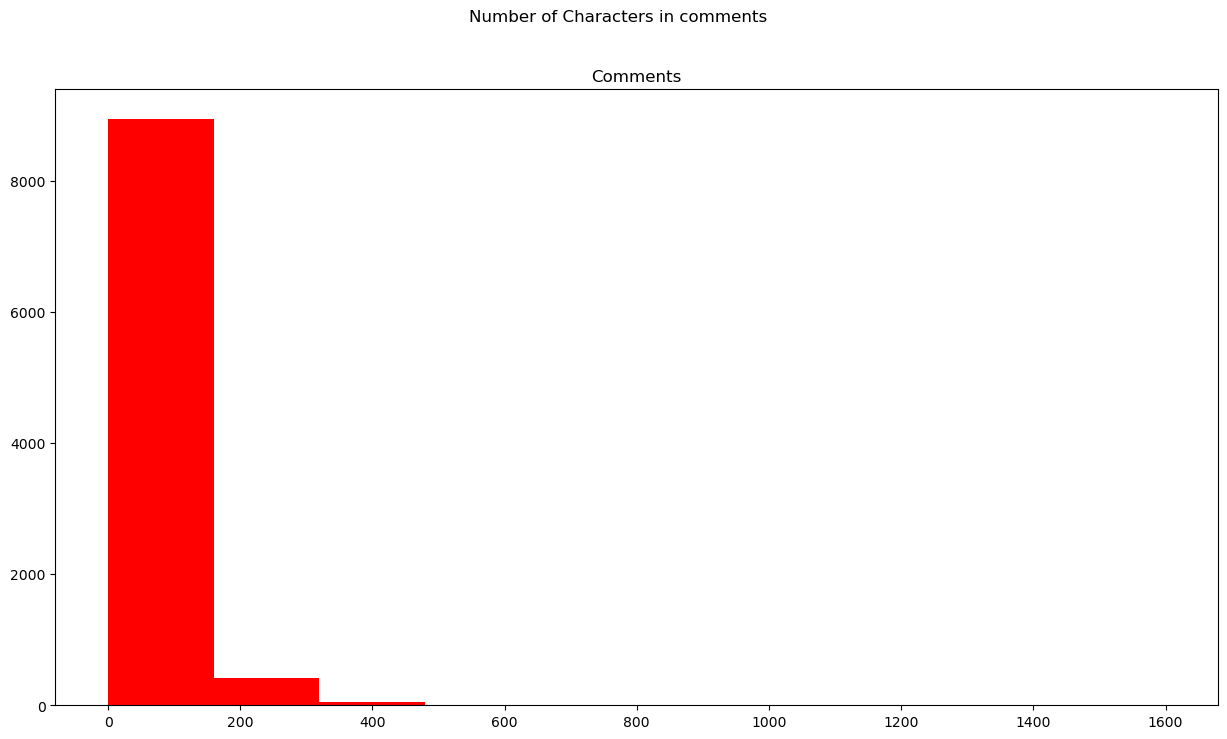

In [13]:
#Visulaization of number of charactor in comments
figure,(neg_ax)=plt.subplots(1,1,figsize=(15,8))
len_comment=df['comments_clean'].str.len()
neg_ax.hist(len_comment,color='red')
neg_ax.set_title('Comments')
figure.suptitle('Number of Characters in comments')
plt.show()

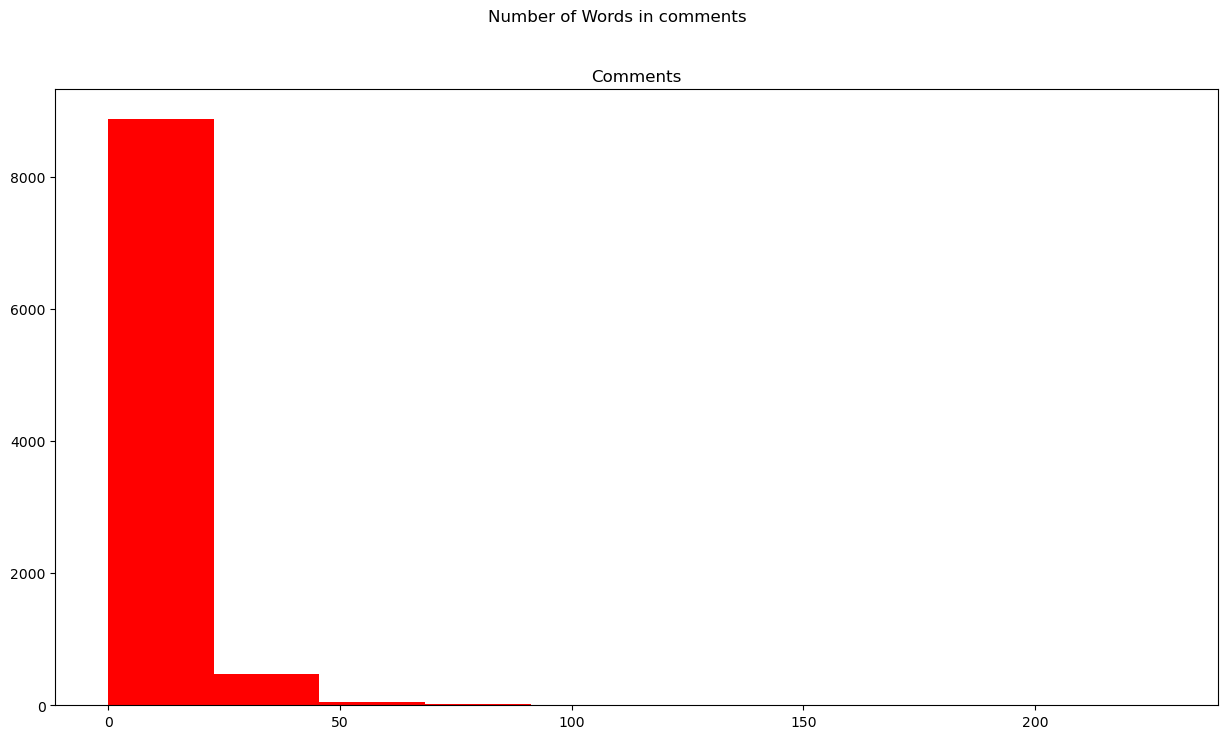

In [14]:
#Visulaization of number of words in comments
figure,(neg_ax)=plt.subplots(1,1,figsize=(15,8))
len_word=df['comments_clean'].str.split().map(lambda comment: len(comment))
neg_ax.hist(len_word,color='red')
neg_ax.set_title('Comments')
figure.suptitle('Number of Words in comments')
plt.show()
neg_word=df['comments_clean'].str.split().map(lambda comment: len(comment))


Text(0.5, 0.98, 'Average word length in Comments')

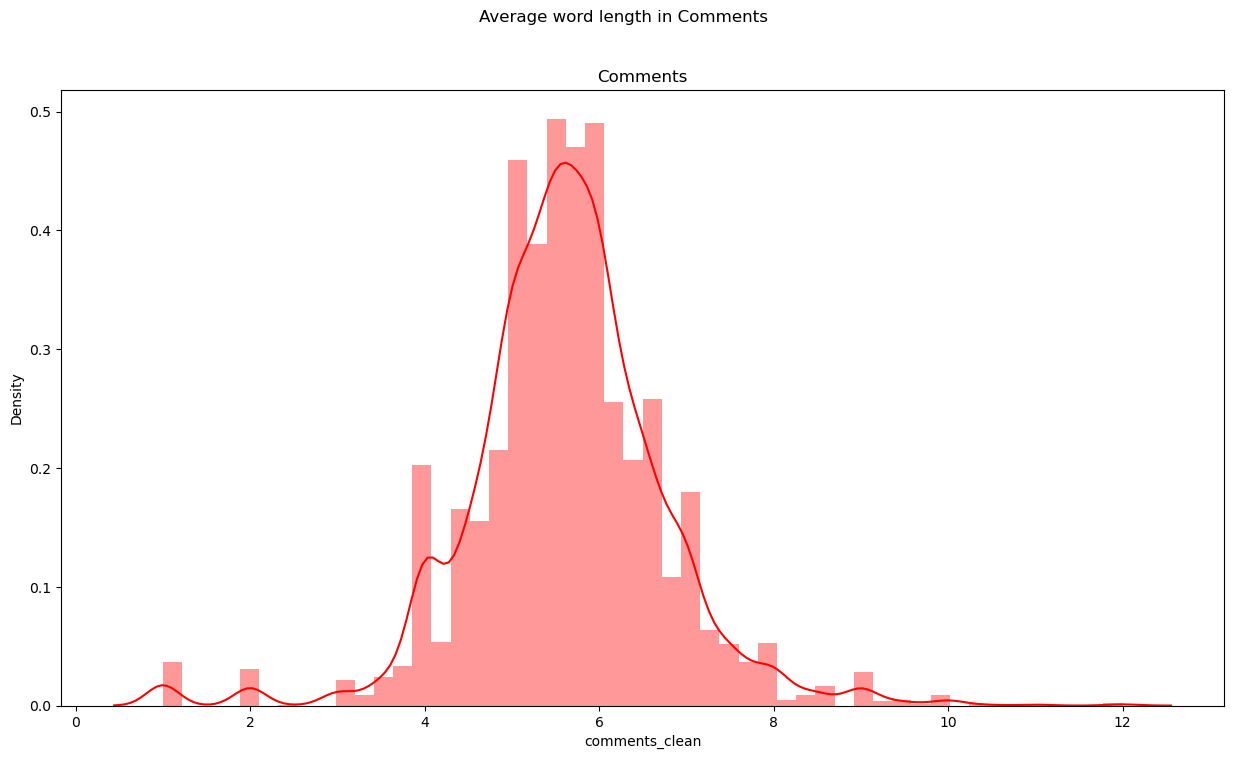

In [15]:
#Visulaize average of words in comments

figure,(neg_ax)=plt.subplots(1,1,figsize=(15,8))
len_word=df['comments_clean'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(len_word.map(lambda x: np.mean(x)),ax=neg_ax,color='red')
neg_ax.set_title('Comments')
figure.suptitle('Average word length in Comments')

In [16]:
#Get important feature by using Countvectorizer
def get_top_text_ngrams(corpus, n, g):
    vec = CountVectorizer(ngram_range=(g, g)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

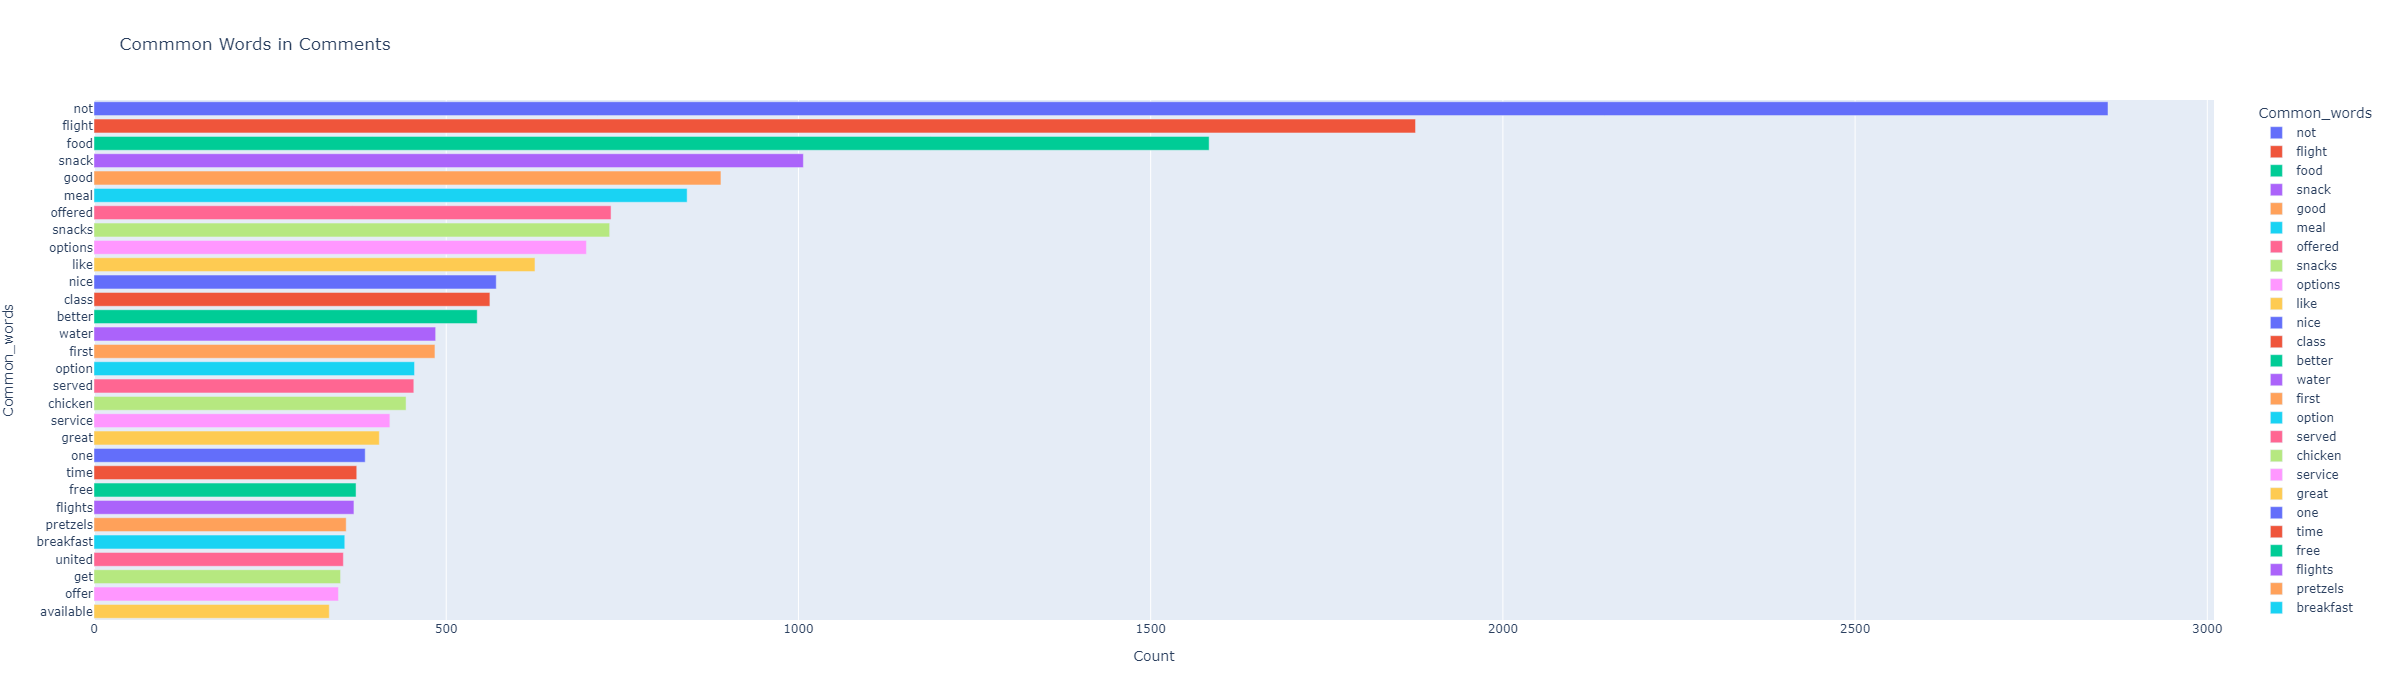

In [17]:
#top 20 unigrams
most_common_uni = get_top_text_ngrams(df.comments_clean,30,1) #list of tuples
most_common_uni = dict(most_common_uni)#dict
temp = pd.DataFrame(columns = ["Common_words" , 'Count'])
temp["Common_words"] = list(most_common_uni.keys())
temp["Count"] = list(most_common_uni.values())
fig = px.bar(temp, x="Count", y="Common_words", title='Commmon Words in Comments', orientation='h', 
             width=700, height=700,color='Common_words')
fig.show()

In [18]:
search_string = "your_search_string_here"

# Filter rows that contain the search string in the 'comments_clean' column
filtered_comments = df[df['comments_clean'].str.contains(search_string, case=False, na=False)]
filtered_comments



Empty DataFrame
Columns: [verbatim_text, comments_clean]
Index: []

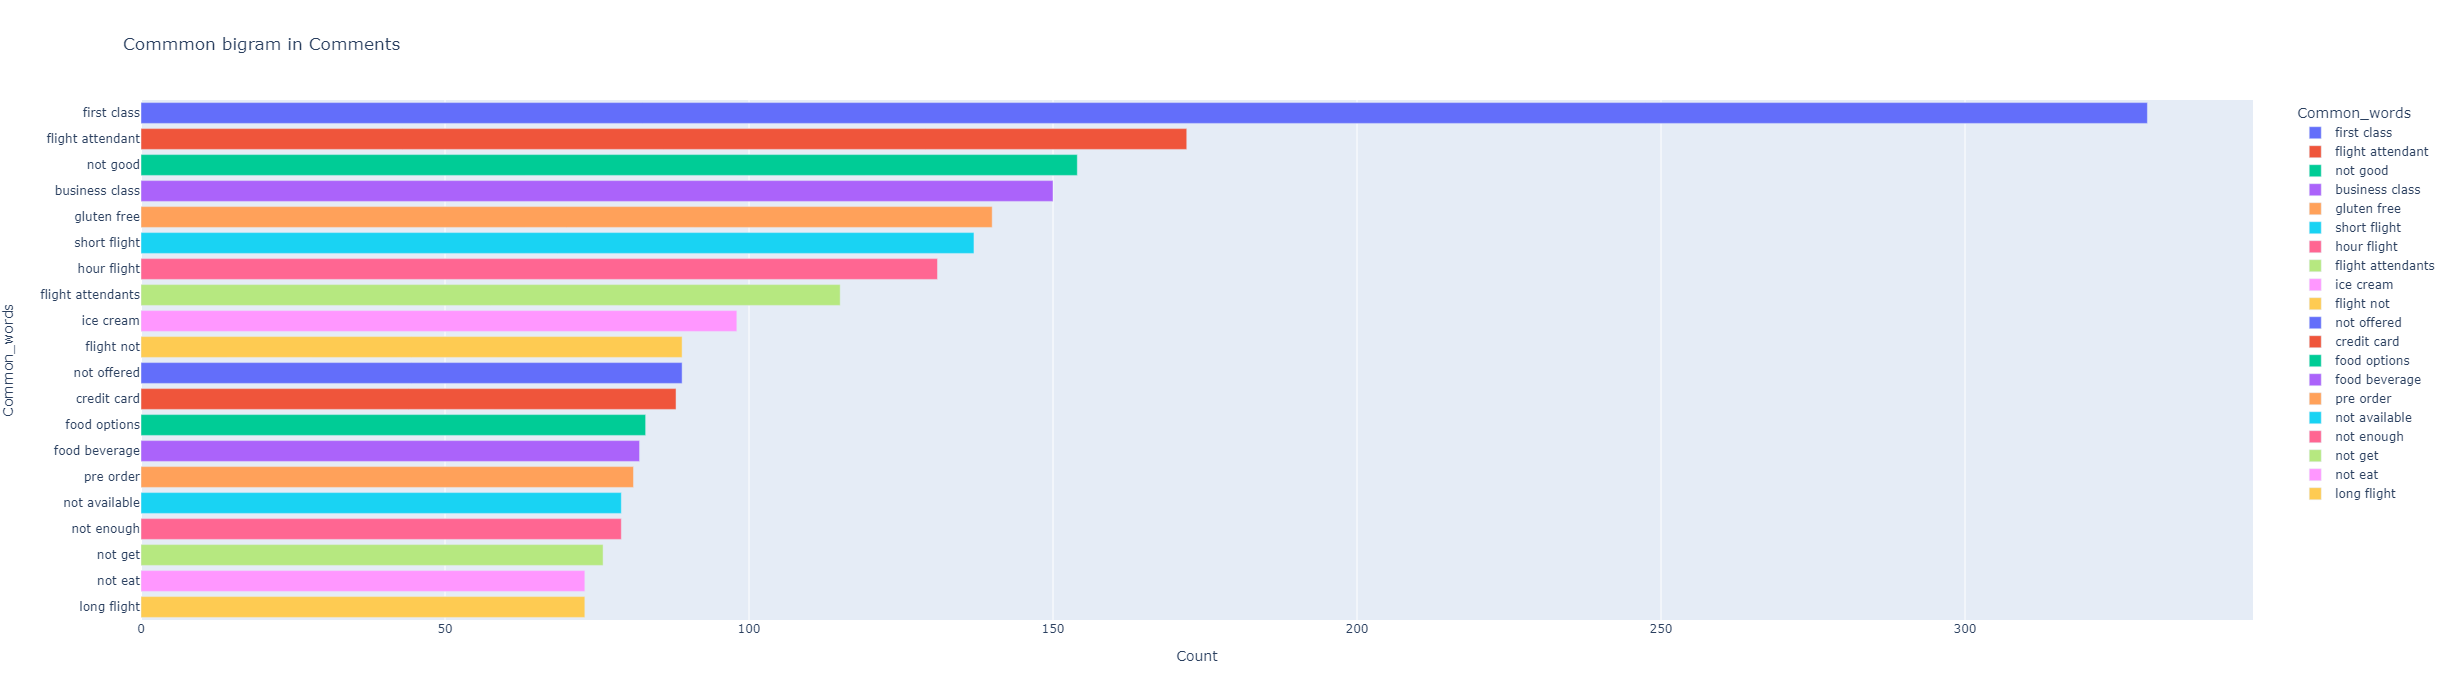

In [19]:
#top 20 bigrams
most_common_uni = get_top_text_ngrams(df.comments_clean,20,2)
most_common_uni = dict(most_common_uni)
temp = pd.DataFrame(columns = ["Common_words" , 'Count'])
temp["Common_words"] = list(most_common_uni.keys())
temp["Count"] = list(most_common_uni.values())
fig = px.bar(temp, x="Count", y="Common_words", title='Commmon bigram in Comments', orientation='h', 
             width=700, height=700,color='Common_words')
fig.show()

In [37]:
search_string = "gluten free"

# Filter rows that contain the search string in the 'comments_clean' column
filtered_comments = df[df['comments_clean'].str.contains(search_string, case=False, na=False)]
filtered_comments['comments_clean']



65                                                                                                                                                                                                                                                                                                                                       loved flavored aha sparkling water thank since took peanuts away gluten free pretzel option amazing
82                                                                                                                                                                                                                                                                                                                                                                    please provide healthier snack options sugar gluten free airplane club
91                                                                                                                                            

In [38]:
search_string = "ice cream"

# Filter rows that contain the search string in the 'comments_clean' column
filtered_comments = df[df['comments_clean'].str.contains(search_string, case=False, na=False)]
filtered_comments['comments_clean']



32                                                                                                                                         unusually flight food quite satisfying tasty little biggerâ especially ice cream given dessert whole good round
56                                                                                                                                                                                                         bring back continental ice cream service please
85                                                                                                                              wish le get yummy desserts wanted ice cream vegetarian not vegan sandwich second meal boring bread cucumber tomato taste ð
163     bring back old continental warm cookie coffee dessert ice cream sundae treats old continental overseas flights offered nearly freeze dried ice cream brownie wafer topping big let houston munich frankfurt dc legs beverage selection good tho

In [39]:
search_string = "flight attendant"

# Filter rows that contain the search string in the 'comments_clean' column
filtered_comments = df[df['comments_clean'].str.contains(search_string, case=False, na=False)]
filtered_comments['comments_clean']



57                                                                                                                                                                                                                        flight attendant hard working friendly
80                                                                                                                                                                                                                                time saw flight attendant good
119                                                                                                                                                                                                       getting soft drink flight attendant always offer whole
123                                                                  first took flight attendants told us snacks previous employees failed refill later gave us choice strop waffles pretzels think found somewhere felt bad flight a

In [40]:
search_string = "credit cards"

# Filter rows that contain the search string in the 'comments_clean' column
filtered_comments = df[df['comments_clean'].str.contains(search_string, case=False, na=False)]
filtered_comments['comments_clean']



558                                                                                                                                                                                             wish still took cash credit cards flight bought
952                                                                                                                                          think allow people use credit cards purchase alcohol beverages board without store credit card app
2148    aware necessity store credit card info website get qr code felt bad couple sitting next not speak english well not able purchase anything not credit cards stored not really know rectify maybe attention given making known passengers
5285                                                                                                                                                                                                   happier make purchase plane credit cards
5410                                    

In [41]:
search_string = "short flight"

# Filter rows that contain the search string in the 'comments_clean' column
filtered_comments = df[df['comments_clean'].str.contains(search_string, case=False, na=False)]
filtered_comments['comments_clean']



22                                                                                                                                                                   short flight offered cup water nice
38                                                                                                                                                           really short flight not even offer us water
209                                                                                                                                                                            short flight service fine
231                                                                                                                                        realize short flight prefer higher quality snack options sale
329                                                                                                                                                                         short flight not expect 

In [20]:
search_string = "first class"

# Filter rows that contain the search string in the 'comments_clean' column
filtered_comments = df[df['comments_clean'].str.contains(search_string, case=False, na=False)]
filtered_comments['comments_clean']



3                                                                                                                                                                                                                                                                                                                                                                                        serving pretzels cookies first class extremely disappointing really little thought chef go long way
33                                                                                                                                                                                                                                                                                            burger lunch meal not taste great especially first class meal heated burger lacking compared ticket price feedback amount times someone came beverage cart compared airlines airlines frequent
64                                            

In [21]:
search_string = "business class"

# Filter rows that contain the search string in the 'comments_clean' column
filtered_comments = df[df['comments_clean'].str.contains(search_string, case=False, na=False)]
filtered_comments['comments_clean']



73                                                                                                                                                                                                                                                                                                                                                                                   wine list business class somewhat expected not get flight
110                                                            nice offered diet options diet coke like diet sprite quality food business class always lacking connected flight europe turkish airlines quality food like comparing star restaurant mcdonalds matter comments highly doubt united get par best airlines food quality business class heard thing travelers many years united obviously not consider priority whereas absolutely
201                                                                                                                                       

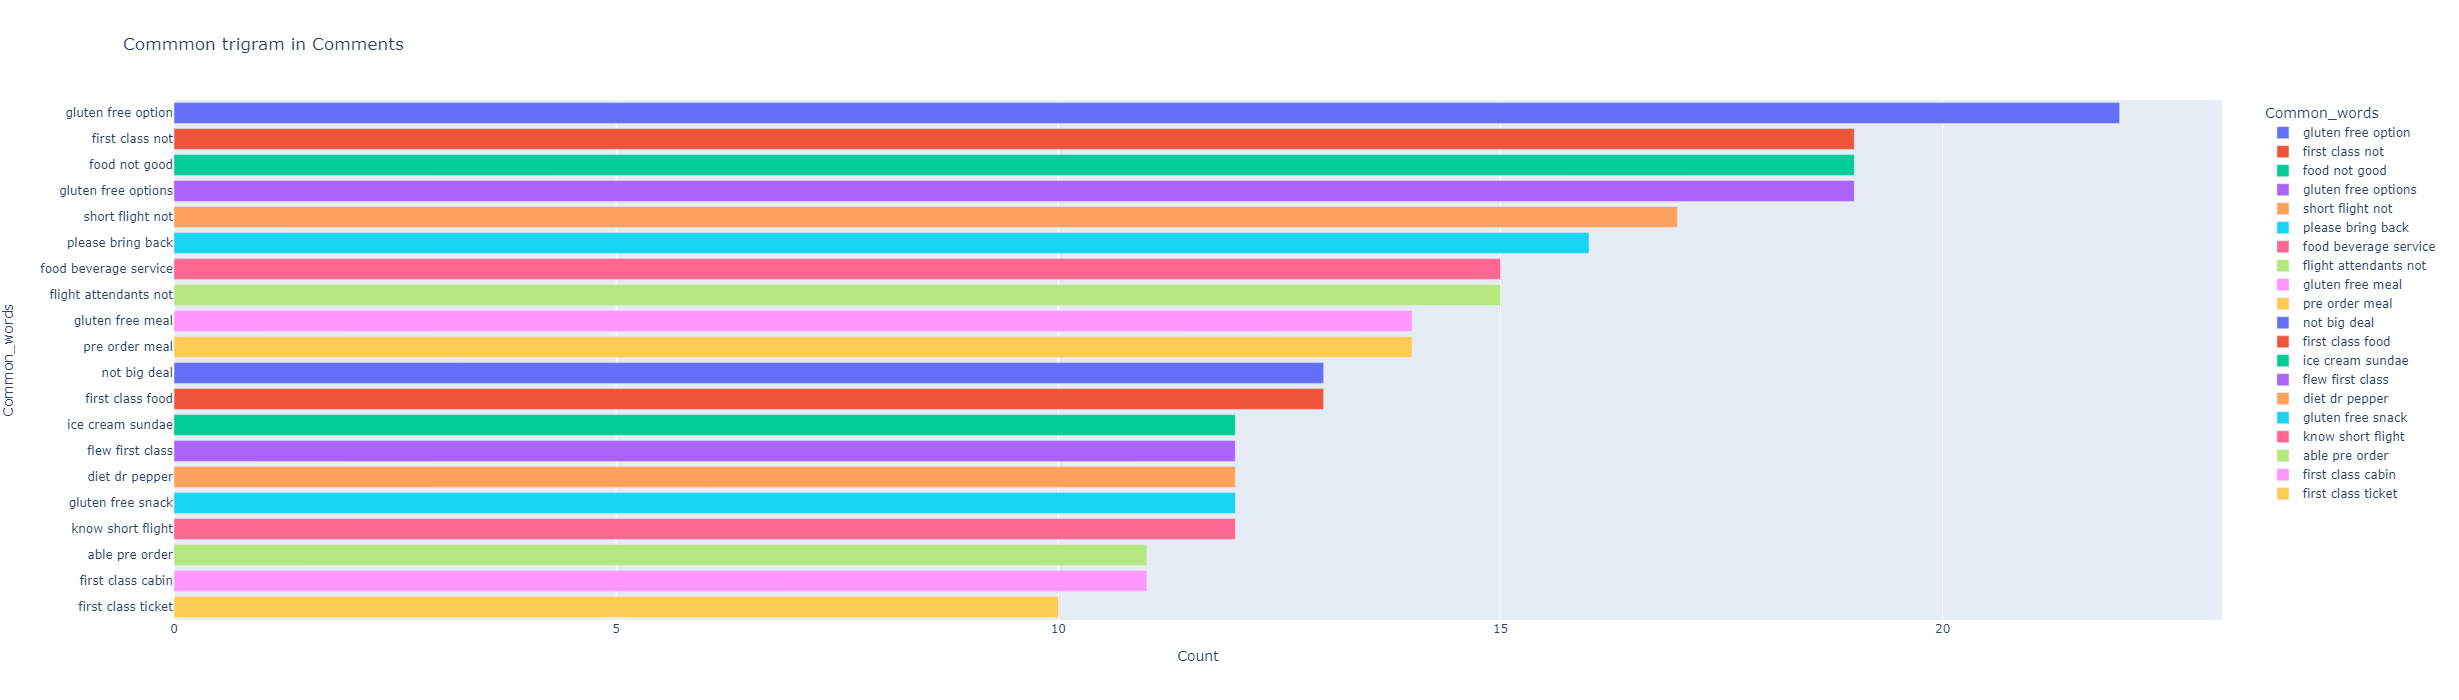

In [22]:
#top 20 trigrams in positive reviews
most_common_uni = get_top_text_ngrams(df.comments_clean,20,3)
most_common_uni = dict(most_common_uni)
temp = pd.DataFrame(columns = ["Common_words" , 'Count'])
temp["Common_words"] = list(most_common_uni.keys())
temp["Count"] = list(most_common_uni.values())
fig = px.bar(temp, x="Count", y="Common_words", title='Commmon trigram in Comments', orientation='h', 
             width=700, height=700,color='Common_words')
fig.show()

In [34]:
search_string = "gluten free option"

# Filter rows that contain the search string in the 'comments_clean' column
filtered_comments = df[df['comments_clean'].str.contains(search_string, case=False, na=False)]
filtered_comments['comments_clean']



634                                                                                                                                                                                                                                                                                                       gluten free option
674                                                                                                                                                                                                                                            nice gluten free option made burger work removing bun quality burger not good
900                                                                                                                                                                                                                                                                                       wish specified gluten free options
1553                                             

In [35]:
search_string = "pre order meal"

# Filter rows that contain the search string in the 'comments_clean' column
filtered_comments = df[df['comments_clean'].str.contains(search_string, case=False, na=False)]
filtered_comments['comments_clean']



914                                                                                                                                                                                                                                                         problem never notified pre order meal tried several times log got app pre order not get first flight received email link return flight never received anything time plane options left neither exciting thank listening
943                                                                                                                                                                                                                                                                                                                               option pre order meal fantastic desert options need small round brownie cookie need bring back cheesecake ice cream option desert seasonal nature
1262                                                            

In [36]:
search_string = "please bring back"

# Filter rows that contain the search string in the 'comments_clean' column
filtered_comments = df[df['comments_clean'].str.contains(search_string, case=False, na=False)]
filtered_comments['comments_clean']



404                                                                                                                                                                                                                                                                                                           hot options please please bring back waffles regardless time day
1580                                                                                                                                                                                                                                                                                                                                            please bring back snack basket
2613                                                                                                                                                                                                                                                                      

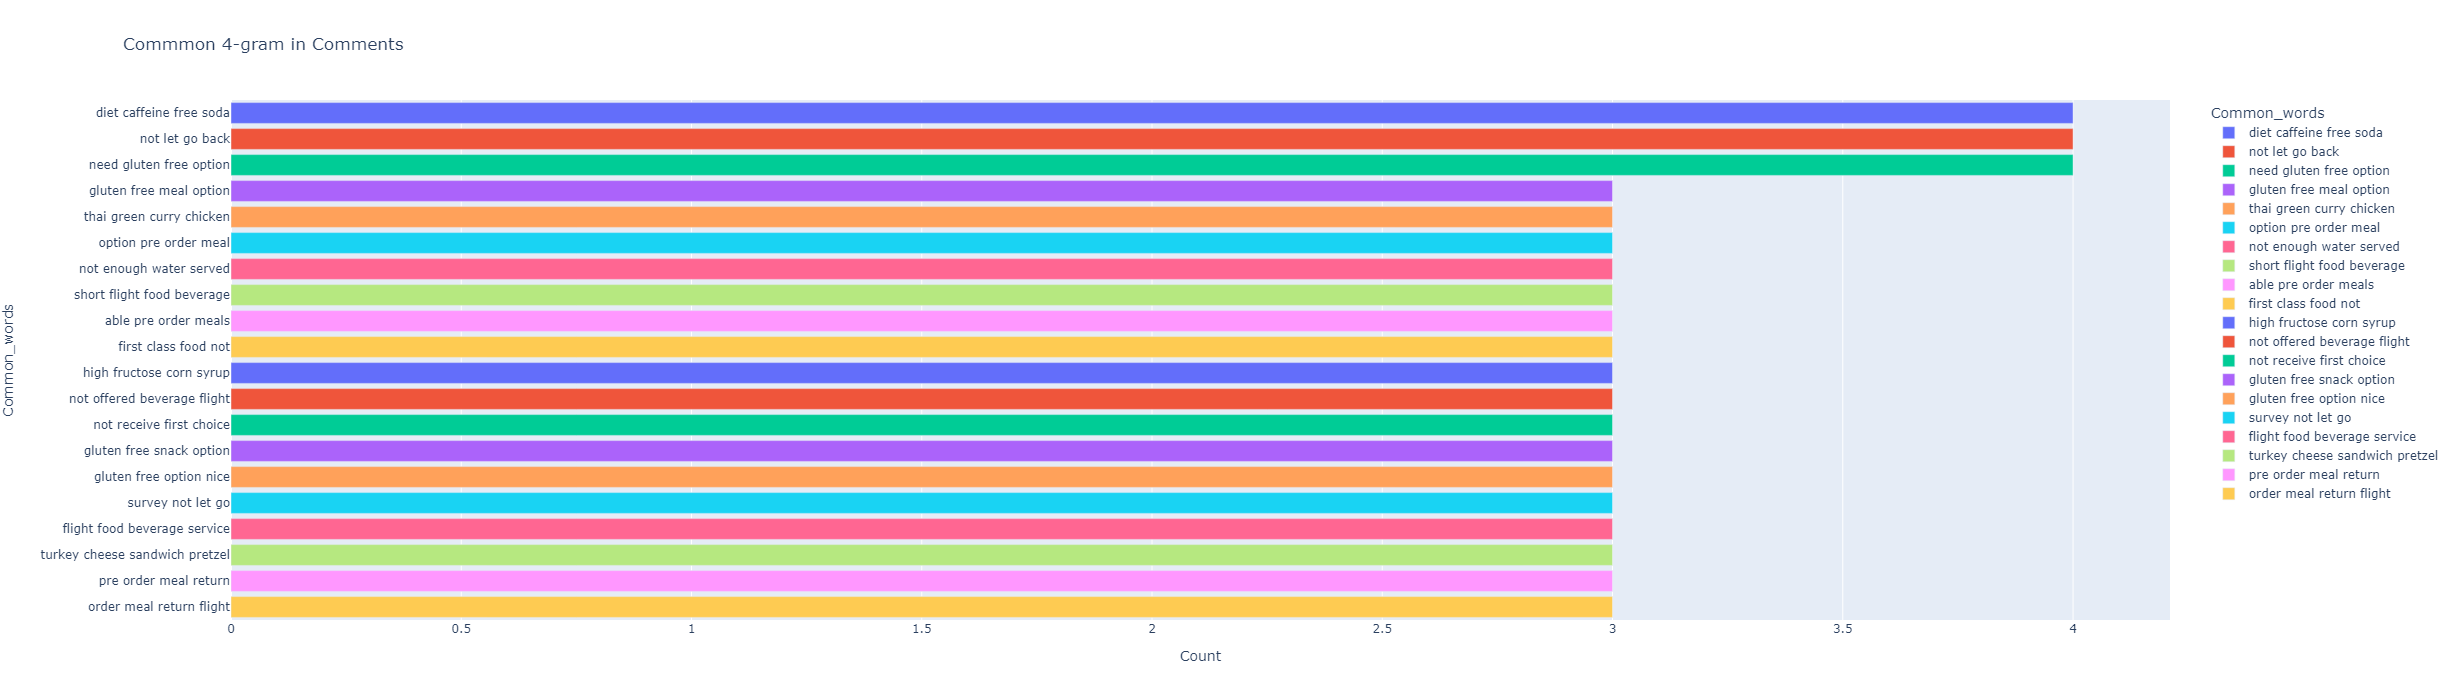

In [23]:
#top 20 4-grams in positive reviews
most_common_uni = get_top_text_ngrams(df.comments_clean,20,4)
most_common_uni = dict(most_common_uni)
temp = pd.DataFrame(columns = ["Common_words" , 'Count'])
temp["Common_words"] = list(most_common_uni.keys())
temp["Count"] = list(most_common_uni.values())
fig = px.bar(temp, x="Count", y="Common_words", title='Commmon 4-gram in Comments', orientation='h', 
             width=700, height=700,color='Common_words')
fig.show()

In [29]:
search_string = "diet caffeine free soda"

# Filter rows that contain the search string in the 'comments_clean' column
filtered_comments = df[df['comments_clean'].str.contains(search_string, case=False, na=False)]
filtered_comments['comments_clean']



49          please add diet caffeine free soda sprite zero diet ginger ale breakfast business breakfast great
3632    meal needs dressing dry lettuce terrible warm option better diet caffeine free soda great diet sprite
4125                                                              wish offer diet caffeine free soda offering
8977     like diet caffeine free soda like diet sprite last night two buyable snack pack options time got row
Name: comments_clean, dtype: object

In [30]:
search_string = "need gluten free option"

# Filter rows that contain the search string in the 'comments_clean' column
filtered_comments = df[df['comments_clean'].str.contains(search_string, case=False, na=False)]
filtered_comments['comments_clean']



4532                                      need gluten free option
5218                                      need gluten free option
7823    need gluten free option first class main course selection
8658                                      need gluten free option
Name: comments_clean, dtype: object

In [32]:
search_string = "gluten free meal option"

# Filter rows that contain the search string in the 'comments_clean' column
filtered_comments = df[df['comments_clean'].str.contains(search_string, case=False, na=False)]
filtered_comments['comments_clean']



91      loved gluten free meal option gluten free snacks available miss gluten free nut option husband ate biscoff
3457         ordered gluten free meal option dinner satisfactory option second meal service luckily brought snacks
9336                                                                                  gluten free meal option nice
Name: comments_clean, dtype: object

In [33]:
search_string = "not enough water served"

# Filter rows that contain the search string in the 'comments_clean' column
filtered_comments = df[df['comments_clean'].str.contains(search_string, case=False, na=False)]
filtered_comments['comments_clean']



992                                                                              not enough water served
1052         not enough water served flight beginning asked flight attendant two bottles water made face
5125    not enough water served matter course drinks offered long time takeoff despite normal conditions
Name: comments_clean, dtype: object

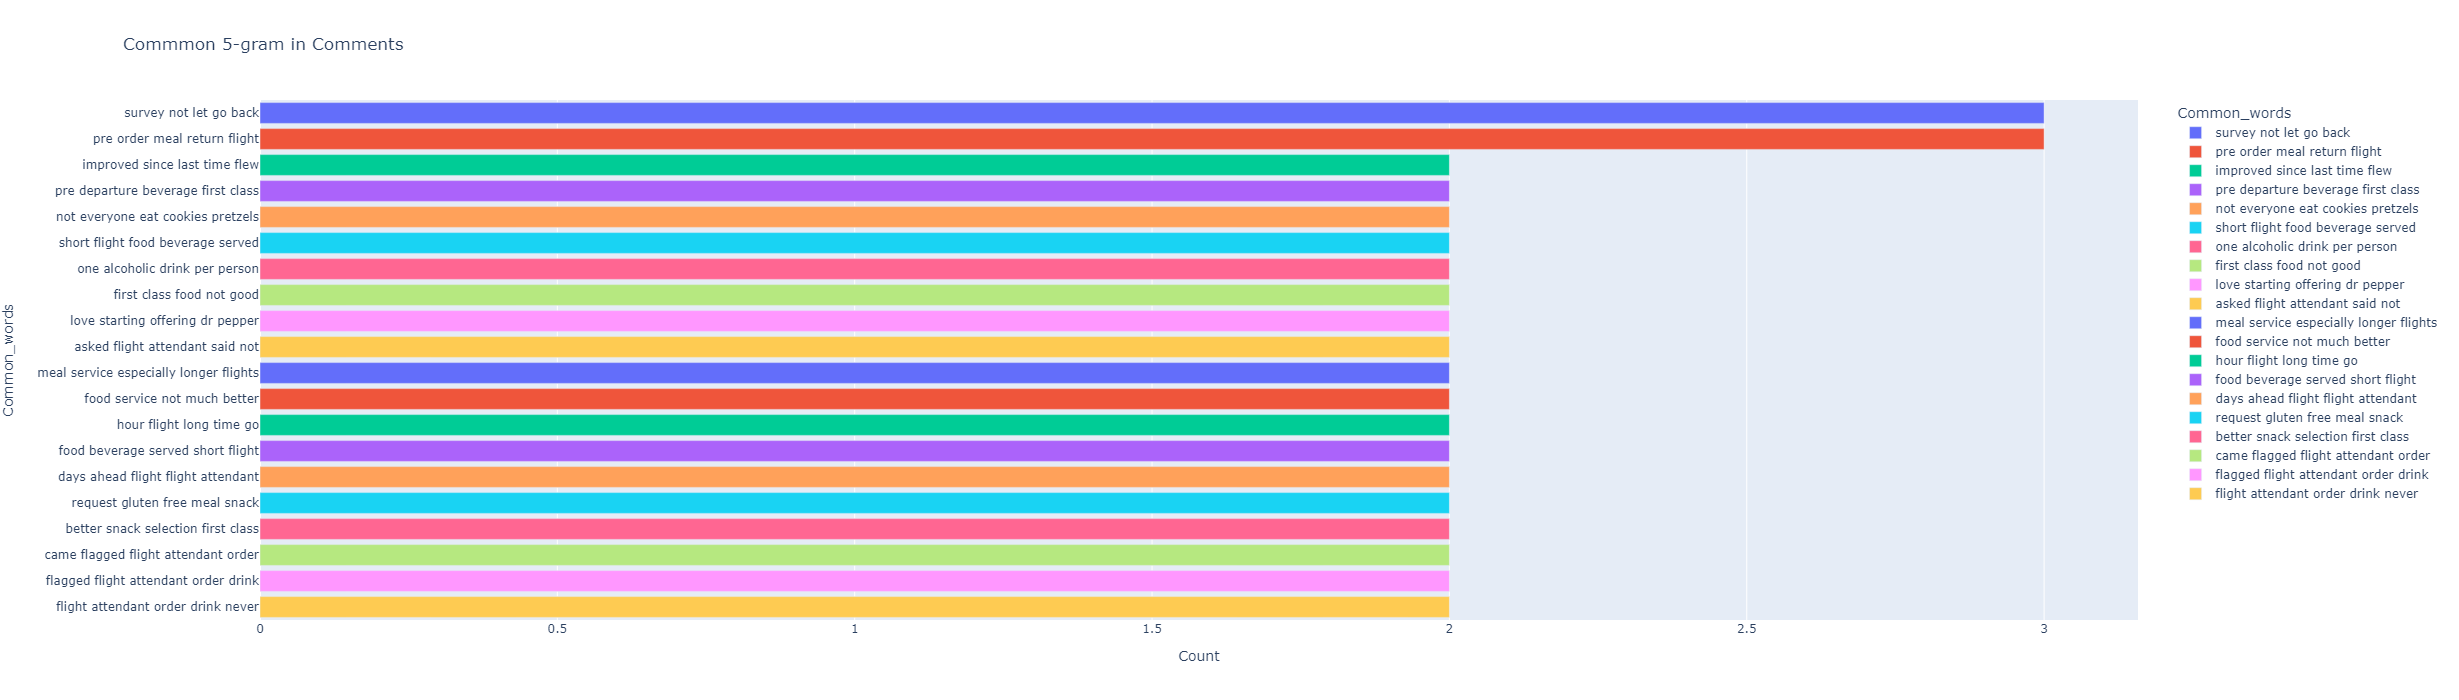

In [24]:
#top 20 5-grams in positive reviews
most_common_uni = get_top_text_ngrams(df.comments_clean,20,5)
most_common_uni = dict(most_common_uni)
temp = pd.DataFrame(columns = ["Common_words" , 'Count'])
temp["Common_words"] = list(most_common_uni.keys())
temp["Count"] = list(most_common_uni.values())
fig = px.bar(temp, x="Count", y="Common_words", title='Commmon 5-gram in Comments', orientation='h', 
             width=700, height=700,color='Common_words')
fig.show()

In [25]:
search_string = "survey not let go back"

# Filter rows that contain the search string in the 'comments_clean' column
filtered_comments = df[df['comments_clean'].str.contains(search_string, case=False, na=False)]
filtered_comments['comments_clean']



3297                                                                                                                                                not offered snack survey not let go back liked getting full ordering complimentary beverage
3702                                                                                                                          sorry not flight survey not let go back legs trip flights need least pretzels cookies us need something chew ears
6751    survey not let go back page correct fact meal not snack main meal fine light snack landing terrible lacking sense called food bland soggy chewy also appeared ran stroopwafels back plane stroopwafel better ham cheese sandwich served
Name: comments_clean, dtype: object

In [28]:

search_string = "pre order meal return flight"

# Filter rows that contain the search string in the 'comments_clean' column
filtered_comments = df[df['comments_clean'].str.contains(search_string, case=False, na=False)]
filtered_comments['comments_clean']



5028                                                                    club service area cancun airport not given option pre order meal return flight cancun sfo chicken selection longer available
6369                                                                                                                                   like ability pre order meal return flight dca sfo not offered
9046    flight boston received e mail pre order meal return flight chicago not not able find web site selected food plane options vegetarian meatballs spicy chicken loved option kind salad instead
Name: comments_clean, dtype: object